In [1]:
import pandas as pd

PriorKnowledgeJossen=pd.read_json('PriorKnowledge.json')

In [2]:
#for data in PriorKnowledgeJossen['data']:
#    print(data['Storage_Temperature'])
StorageTemperatures=[data['Storage_Temperature'] for data in PriorKnowledgeJossen['data']]
UsedStoredSpecificEnergy=[data['Used_Stored_Specific_Energy'] for data in PriorKnowledgeJossen['data']]
# years to 80% in DOE
# days to loose 1Wh/kg in Enpolite to years to loose 20%
# LifetimeCoefficient/(max(UsedStoredSpecificEnergy)*100/365)
Lifetime=[data['Lifetime_Coefficient']/(max(UsedStoredSpecificEnergy)*100/365) for data in PriorKnowledgeJossen['data']]

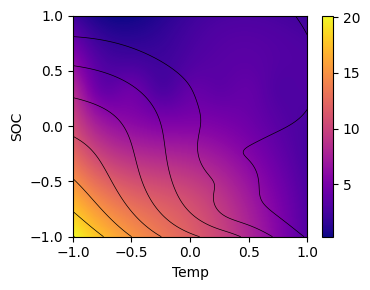

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from scipy.interpolate import griddata

# Sample data

# Function to normalize to a specific range
def normalize(data, new_min, new_max):
    data_min = np.min(data)
    data_max = np.max(data)
    return (new_max - new_min) * (data - data_min) / (data_max - data_min) + new_min

# Normalize x and y to the range [-1, 1]
x_normalized = normalize(StorageTemperatures, -1, 1)
y_normalized = normalize(UsedStoredSpecificEnergy, -1, 1)

# Normalize z to the range [0, 1]
z_normalized = Lifetime#normalize(LifetimeCoefficient, 0, 1)

# Create grid values for interpolation
grid_x, grid_y = np.mgrid[-1:1:200j, -1:1:200j]

# Interpolate the data
grid_z = griddata((x_normalized, y_normalized), z_normalized, (grid_x, grid_y), method='cubic')

# Interpolate the data using Rbf
rbf = Rbf(x_normalized, y_normalized, z_normalized, function='cubic')
grid_z = rbf(grid_x, grid_y)

# Create the plot
plt.figure(figsize=(4, 3))  # Smaller figure size for a minimalistic look
plt.imshow(grid_z, extent=(-1, 1, -1, 1), origin='lower', cmap='plasma', aspect='auto')
plt.colorbar()
plt.xlabel('Temp')
plt.ylabel('SOC')
plt.tight_layout()  # Use tight layout for minimalistic look
plt.grid(False)  # Remove grid for minimalistic look

# Add contour lines
contours = plt.contour(grid_x, grid_y, grid_z, levels=8, colors='black', linewidths=0.5)
#plt.clabel(contours, inline=True, fontsize=8)

plt.show()